In [2]:
import scipy
import numpy as np
from matplotlib import cm,colors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [3]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [76]:
delta_t = 1e-9
rho = 2200
index_refraction = 1.4440
T = 293
p = 1e-6
radius = 71.5e-9
wavelength = 1.064e-6
power = 400e-3
eta_detection = 0.178#0.178
control_step = int(30e-9/delta_t) 
fs = 1/(control_step*delta_t)
cavity_waist = 10e-6 #only affects theoretical opmech coupling
cavity_length = 0.03
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.38
optomechanical_coupling_ratio = 0.25
g_fb_ratio = 5
laser_linewidth = 0

In [77]:
gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,
                                    T = T, rho = rho, index_refraction = index_refraction)

zp_x = compute_zpx(omega, radius, rho = rho)
std_detection = std_detection/zp_x

period = 2*np.pi/omega
t = np.arange(0, 500*period, delta_t)
N = t.shape[0]

coupling = (1/(4*np.pi))*(ba_force**2)

In [78]:
cavity_linewidth = cavity_linewidth_ratio * omega
g_cs = optomechanical_coupling_ratio * omega
env = Cavity_Particle(
    omega,
    gamma,
    detuning,        
    cavity_linewidth,
    g_cs,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T,
    g_fb_ratio = g_fb_ratio
)

In [79]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = control_step*delta_t/2*np.array(
    [
        [env.__shot_std__**2, 0, 0, 0],
        [0, env.__shot_std__**2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process]
    ])
R = np.array([[np.power(std_detection, 2)]])
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cov_ss = dare(np.transpose(Ad), Bd, Q, R)[0]

In [80]:
def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos

In [85]:
photon_number = 0.1
runs = 1
step = 50
metrics = {''}
SNR_data = []

env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*omega,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T
)
optical_input, centers, pulse_width = create_pulse(photon_number, env.__kappa__, 
                                                   laser_linewidth, t,
                                                   cavity_length, env.__detuning__)
x0 = 0
P0 = 1
SNR_pos = []
SNR_phn = []
SNR_fid = []
for run in tqdm(range(runs)):
    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
        env.A,
        env.B, 
        optical_input,
        env.thermal_force_std,
        env.backaction_std,
        env.__shot_std__,
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        env.G_lqr,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )
    pos = estimated_states[:,2][::control_step]
    #pos_rise, pos_acomm, pos_left, pos_right = compute_times(pos, delta_t*control_step)
    #SNR_pos = np.append(compute_SNR(pos, pos_left, pos_right),SNR_pos)

    phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step)
    #phn_rise, phn_acomm, phn_left, phn_right = compute_times(phonons, delta_t*control_step*step)
    #SNR_phn = np.append(compute_SNR(phonons, phn_left, phn_right), SNR_phn)

    #fidelity = compute_fidelity(estimated_states, cov_aposteriori, cov_ss, control_step, step=step)
    #fid_rise, fid_acomm, fid_left, fid_right = compute_times(fidelity,delta_t*control_step*step)
    #SNR_fid = np.append(compute_SNR(fidelity, phn_left, phn_right),SNR_fid)
    #mean_pos, std_pos = post_process_snr(SNR_pos)
    #mean_phn, std_phn = post_process_snr(SNR_phn)
    #mean_fid, std_fid = post_process_snr(SNR_fid)      

#SNR_data.append([[mean_pos, std_pos], [mean_phn, std_phn], [mean_fid, std_fid]])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.81s/it]


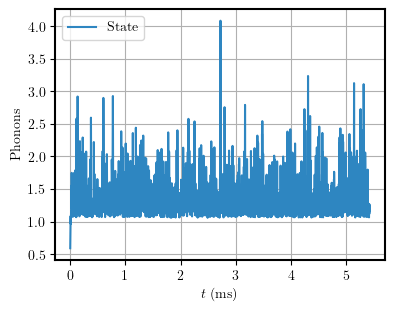

In [89]:
signal = phonons
#signal = 1/(fidelity/(max(fidelity))) - 1

colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure()
factor = 1
fig.set_size_inches(4.25*factor, 3.25*factor, forward=True)

#plt.plot(1e3*t[::control_step], new_states[::control_step, 2]*zp_x/1e-9, color=colors[2], alpha = 0.3)
#plt.plot(1e3*t[::control_step],estimated_states[:,2][::control_step]*zp_x/1e-9,color = colors[0], alpha = 0.5)
#plt.ylabel(r'$z(t)$ (nm)')

#plt.plot(1e3*t[::control_step], measured_states[::control_step]*zp_x/1e-9, color = colors[2], alpha=0.3)#, alpha = 0.3, label = 'Measurement')

x = 1e3*t[::control_step][::step][:signal.shape[0]]
plt.plot(x, signal, color = colors[0])
plt.ylabel(r'Phonons')

plt.xlabel(r'$t$ (ms)')

plt.grid()
plt.legend(['State', 'Estimation'],loc = 'upper left')
plt.show() 
#ax.text(0.2, 0.8, r'SNR = {:.2}dB'.format(10*np.log10(SNR)), fontsize=15)